<a href="https://colab.research.google.com/github/argenis-gomez/Cats-and-Dogs/blob/main/Clasificador_de_perros_y_gatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de perros y gatos

En el siguiente notebook crearemos un clasificador de perros y gatos utilizando un dataset de Kaggle con 8000 imágenes para entrenamiento (4000 imágenes de perros, 4000 imágenes de gatos) y 2000 imágenes para validación

## Descarga del dataset

In [ ]:
!cp "drive/MyDrive/kaggle.json" "/root/.kaggle/kaggle.json"
!kaggle datasets download -d tongpython/cat-and-dog --unzip

 94% 205M/218M [00:01<00:00, 203MB/s]
100% 218M/218M [00:01<00:00, 204MB/s]


## Librerías a utilizar

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

## Variables globales

In [ ]:
tf.random.set_seed(905)
BATCH_SIZE = 16
CLASS_MODE = 'binary'
INPUT_SHAPE = (64, 64)
DROPOUT = 0.25
CHECK_PATH = '/content/drive/MyDrive/Cat&Dogs/'

## Data Augmentation

Debido a que poseemos un dataset pequeno, utilizaremos esta técnica para generar modificaciones en las imágenes existente y simular un dataset más grande.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=0.3,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_ds = train_datagen.flow_from_directory(
    './training_set/training_set',
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True
)

test_ds = test_datagen.flow_from_directory(
    './test_set/test_set',
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True
)

## Modelo

Utilizaremos un modelo convolucional con 4 niveles de convolución, aplicando BatchNormalization para mejorar el comportamiento del modelo y disminuir los tiempos de convergencia.
Utilizaremos Dropout y Regularizers para disminuir el Overfiting.

In [ ]:
initializer = tf.random_normal_initializer(0., 0.02)
regularizer = tf.keras.regularizers.L2(0.005)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer, input_shape=INPUT_SHAPE + (3,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, padding='same'),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, padding='same'),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, padding='same'),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_initializer=initializer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(2, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=regularizer),
    ]
)

In [ ]:
LR = 2e-4
BETA = 0.5
model.compile(optimizer=tf.keras.optimizers.Adam(LR, BETA),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Entrenamiento

Entrenaremos por 100 epocas, utilizando un Early Stop para detener el entrenamiento en caso de que no esté aprendiendo el modelo y reducir los tiempos de espera.

In [ ]:
hist = model.fit(train_ds,
                 epochs=100,
                 validation_data=test_ds,
                 callbacks=[early_stop])

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/100
501/501 [==============================] - 40s 65ms/step - loss: 2.1795 - accuracy: 0.6434 - val_loss: 1.3608 - val_accuracy: 0.5709
Epoch 2/100
501/501 [==============================] - 32s 65ms/step - loss: 1.0738 - accuracy: 0.7161 - val_loss: 0.7758 - val_accuracy: 0.7736
Epoch 3/100
501/501 [==============================] - 32s 64ms/step - loss: 0.7549 - accuracy: 0.7422 - val_loss: 0.6157 - val_accuracy: 0.7701
Epoch 4/100
501/501 [==============================] - 32s 64ms/step - loss: 0.6238 - accuracy: 0.7652 - val_loss: 0.6009 - val_accuracy: 0.7612
Epoch 5/100
501/501 [==============================] - 32s 64ms/step - loss: 0.5693 - accuracy: 0.7682 - val_loss: 0.5445 - val_accuracy: 0.7781
Epoch 6/100
501/501 [==============================] - 32s 64ms/step - loss: 0.5311 - accuracy: 0.7920 - val_loss: 0.5504 - val_accuracy: 0.7657
Epoch 7/100
501/501 [=========================

El modelo tuvo un val_loss de 0.3570 y un val_acc de 0.8858.

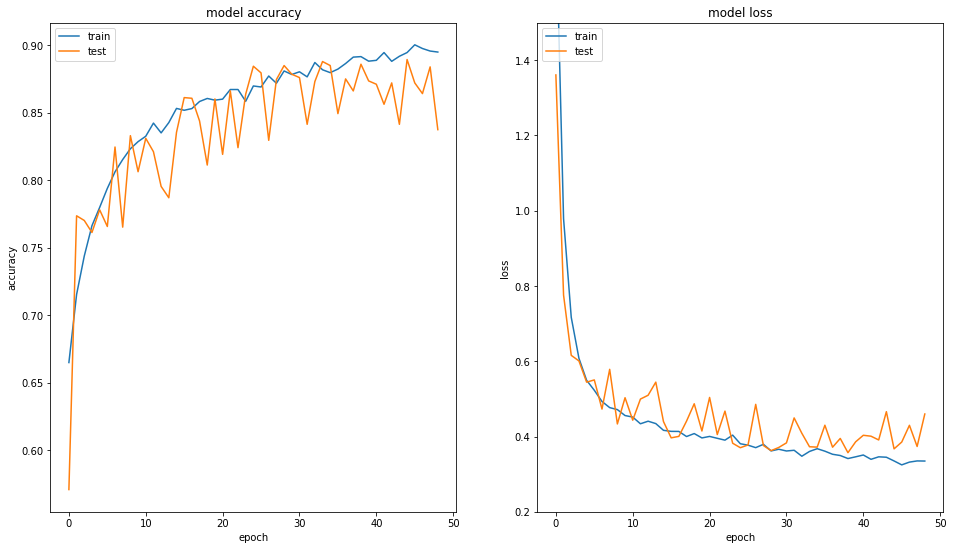

In [ ]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylim(0.2, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Luego de finalizar el entrenamiento se realizó un fine tuning utilizando un lr de 1e-6 para mejorar el modelo.

In [ ]:
model.evaluate(test_ds)

127/127 [==============================] - 5s 37ms/step - loss: 0.2780 - accuracy: 0.9036


[0.278037428855896, 0.903608500957489]

In [ ]:
model.save(CHECK_PATH+'model_acc90.h5')

## Resultados

Observaremos algunas predicciones realizadas por el modelo.

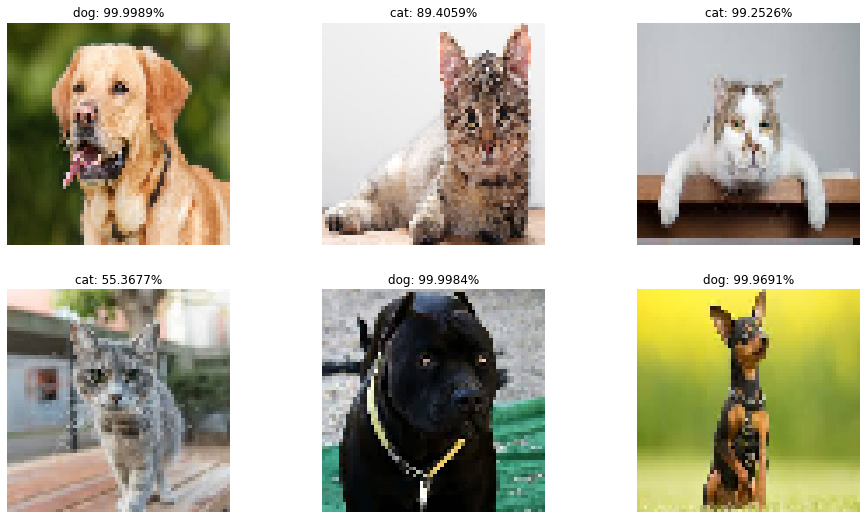

In [ ]:
plt.figure(figsize=(16, 9))
for n in range(1, 7):
  img = f'/content/cat_or_dog_{n}.jpg'

  test_image = image.load_img(img, target_size = (64, 64))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0) / 255.
  result = model.predict(test_image)

  if result[0][0] > .5:
      prediction = 'dog'
      prob = result[0][0]*100
  else:
      prediction = 'cat'
      prob = (1 - result[0][0])*100

  plt.subplot(2, 3, n)
  plt.imshow(np.squeeze(test_image))
  plt.title(f'{prediction}: {prob:2.4f}%')
  plt.axis('off')

plt.show()